# Predicting Disease Associate Genes Relationship (Part 2)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


from collections import OrderedDict
import glob
import os
import pickle
import re
import sys

sys.path.append(os.path.abspath('../../../modules'))
sys.path.append(os.path.abspath('../'))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

import torch
import torch.nn as nn

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.models import Candidate, candidate_subclass
from cnn import PaddedEmbeddings, CNN
from metal.modules import LSTMModule
from metal.modules.lstm_module import EmbeddingsEncoder
from metal.end_model import EndModel

from utils.notebook_utils.label_matrix_helper import label_candidates
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes
from utils.notebook_utils.plot_helper import plot_curve, plot_label_matrix_heatmap
from utils.notebook_utils.train_model_helper import get_attn_scores, get_network_results

In [4]:
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [19]:
spreadsheet_names = {
    #'train': 'multitask_experiment/data/sentences/sentence_labels_train.xlsx',
    'dev': 'data/sentences/sentence_labels_dev.xlsx',
    'test': 'data/sentences/sentence_labels_test.xlsx',
}

In [20]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key])
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 1000
Size of test set: 1000


In [133]:
dg_map_df = pd.read_table("../dataset_statistics/all_dg_candidates_map.tsv.xz")
dg_map_df.head(2)

,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.8586,1,0.0,1.0,3.0,2129459,The number of H antigen sites per single red c...,172,176680
1,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.8586,1,0.0,1.0,3.0,2129459,The number of H antigen sites per single red c...,172,176675


In [22]:
dev_data = pd.read_table("single_task_data/dev_dataframe.tsv.xz").sort_values("candidate_id")
dev_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,candidate_id,sen_length
0,9,529,2,2963,72,26,9,14475,436,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21841,63
1,15,36,21,2051,10,8,1,12,394,32771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82680,72


In [23]:
test_data = pd.read_table("single_task_data/test_dataframe.tsv.xz").sort_values("candidate_id")
test_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,candidate_id,sen_length
0,3914,192,8,15,10719,10,7465,1016,142,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23356,50
1,9,584,20,3,22521,4,28,66,94,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23367,22


In [24]:
word_vectors = pd.read_table(
    "single_task_data/training_word_vectors.bin", 
    sep=" ", skiprows=1,
    header=None,index_col=0, 
    keep_default_na=False
)
word_vectors.head(2)

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
of,-0.011309,-0.086732,-0.048526,0.014612,-0.045023,-0.220397,-0.242358,0.060525,0.167045,-0.288198,...,0.000426,-0.005404,-0.021657,-0.102170,0.200634,0.187765,0.025791,-0.044495,-0.034465,-0.031029
~~[[2,-0.179990,0.167300,-0.507239,0.111690,-0.269776,-0.256630,0.207848,-0.187613,0.456848,-0.358285,...,0.285407,0.042137,0.371122,-0.173622,-0.534416,0.248068,-0.239652,-0.370680,-0.199664,-0.010923


In [25]:
cutoff = 60

In [26]:
dev_X = torch.LongTensor(
    dev_data
    .query("sen_length < @cutoff")
    [[col for col in dev_data.columns if col in list(map(lambda x: str(x),range(cutoff-1)))]]
    .fillna(0)
    .values
)
dev_Y = torch.LongTensor(
    dev_data
    .query("sen_length < @cutoff")
    .merge(candidate_dfs['dev'])
    .curated_dsh
    .apply(lambda x: 1 if x > 0 else 2)
    .values
)

test_X = torch.LongTensor(
    test_data
    .query("sen_length < @cutoff")
    [[col for col in test_data.columns if col in list(map(lambda x: str(x),range(cutoff-1)))]]
    .fillna(0)
    .values
)
test_Y = torch.LongTensor(
    test_data
    .query("sen_length < @cutoff")
    .merge(candidate_dfs['test'])
    .curated_dsh
    .apply(lambda x: 1 if x > 0 else 2)
    .values
)

In [27]:
gen_model_dev_df = (
    pd.read_table("single_task_data/gen_model_dev_set_pred.tsv")
    .merge(dev_data.query("sen_length < @cutoff"), on="candidate_id")
    .sort_values("candidate_id")
)
gen_model_test_df = (
    pd.read_table("single_task_data/gen_model_test_set_pred.tsv")
    .merge(test_data.query("sen_length < @cutoff"), on="candidate_id")
    .sort_values("candidate_id")
)

# LSTM Network Evaluation

Used a LSTM network with an attention layer at the end. The following parameters for the network is produced below in the table:

| Parameter | Network 1 | Network 2 | Network 3 | Network 4
|-------|-------|-------|-------|-------|
| Word Embeddings | 300 dim (fixed) | 300 dim (fixed) | 300 dim (fixed) | 300 dim (fixed) |
| Hidden State | 50 Dim |  100 Dim | 250 Dim |  300 Dim |
| Dropout | 0.25 (outside) and 0.25 (inside) | 0.25 (outside) and 0.25 (inside) | 0.25 (outside) and 0.25 (inside) | 0.25 (outside) and 0.25 (inside) | 
| Layers | 2 | 2 | 2 | 2 |
| learning rate | 0.01 |  0.01 |  0.01 |  0.01 | 
| optimizer | adam with betas(0.9, 0.99)| adam with betas(0.9, 0.99)| adam with betas(0.9, 0.99)| adam with betas(0.9, 0.99)|
| Batch Size | 256 | 256 | 256 | 256 | 
    

In [28]:
lstm_params = {
    "LSTM Network 1":
    {
        "hidden_size":50,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
    },
    "LSTM Network 2":
    {
        "hidden_size":100,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
    },
    "LSTM Network 3":
    {
        "hidden_size":250,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
    },
    "LSTM Network 4":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
    },
}

In [38]:
lstm_model_paths = {
    "LSTM Network 1":sorted(
            glob.glob("single_task_data/final_models/fixed_index/lstm/300_50_frozen_both_dropout_0.25/*checkpoint*"), 
            key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 2":sorted(
            glob.glob("single_task_data/final_models/fixed_index/lstm/300_100_frozen_both_dropout_0.25/*checkpoint*"),
            key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 3":sorted(
        glob.glob("single_task_data/final_models/fixed_index/lstm/300_250_frozen_both_dropout_0.25/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 4":sorted(
        glob.glob("single_task_data/final_models/fixed_index/lstm/300_300_frozen_both_dropout_0.25/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    )
}


In [34]:
lstm_end_models = {}

In [35]:
for key in lstm_params:
    lstm_end_models[key] = EndModel(
        [lstm_params[key]["max_dim"], lstm_params[key]["hidden_size"]*2, lstm_params[key]["output_size"]], 
        middle_modules=[LSTMModule(
                encoded_size=lstm_params[key]["word_embeddings"],
                hidden_size=lstm_params[key]["hidden_size"],
                lstm_reduction='attention',
                lstm_num_layers=lstm_params[key]['num_layers'],
                encoder_class=EmbeddingsEncoder,
                encoder_kwargs={
                "vocab_size":lstm_params[key]["vocab_size"],
                "freeze":lstm_params[key]["freeze_embeddings"],
                "seed":lstm_params[key]["seed"],
                }
                )],
        seed=lstm_params[key]["seed"], 
        use_cuda=False,
        middle_layer_config = {
        'middle_relu':False,
        'middle_dropout': lstm_params[key]["outside_dropout"],
        'middle_batchnorm':False,
        },
    )    

Using randomly initialized embeddings.
Embeddings shape = (54074, 300)
The embeddings are FROZEN
Using lstm_reduction = 'attention'

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): LSTMModule(
      (encoder): EmbeddingsEncoder(
        (embeddings): Embedding(54074, 300)
      )
      (lstm): LSTM(300, 50, num_layers=2, batch_first=True, bidirectional=True)
    )
    (1): Dropout(p=0.25)
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

Using randomly initialized embeddings.
Embeddings shape = (54074, 300)
The embeddings are FROZEN
Using lstm_reduction = 'attention'

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): LSTMModule(
      (encoder): EmbeddingsEncoder(
        (embeddings): Embedding(54074, 300)
      )
      (lstm): LSTM(300, 100, num_layers=2, batch_first=True, bidirectional=True)
    )
    (1): Dropout(p=0.25)
  )
  (2): Linear(in_features=200, out_features=2, bias=True)
)

Using ran

In [39]:
lstm_results = {}
for network in lstm_model_paths:
    lstm_results[network] = get_network_results(
        lstm_model_paths[network], lstm_end_models[network], 
        dev_X, test_X
    )

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

In [40]:
lstm_results[network][0].head(2)

,epoch,train_loss,val_loss,lr,f1
0,0.0,0.380290,1.638677,0.01,0.558783
1,1.0,0.273872,1.438570,0.01,0.566248


In [41]:
lstm_results[network][1].head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.180310,0.122020,0.163349,0.140104,0.151111,0.131906,0.169461,0.162342,0.142475,0.127365,...,0.165548,0.164677,0.164789,0.163413,0.164268,0.165289,0.166314,0.165241,0.16701,0.165010
1,0.144775,0.113085,0.146906,0.125287,0.117989,0.121528,0.147876,0.125120,0.124552,0.119923,...,0.141940,0.141959,0.141132,0.139672,0.141137,0.142010,0.142442,0.140554,0.14339,0.141686


In [42]:
lstm_results[network][2].head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.043982,0.031249,0.045988,0.030121,0.041085,0.033779,0.045396,0.046046,0.045258,0.031695,...,0.039183,0.037560,0.037558,0.037192,0.038347,0.036785,0.038439,0.037013,0.037809,0.037229
1,0.173693,0.118218,0.153860,0.132384,0.138314,0.126766,0.160173,0.156411,0.143816,0.126337,...,0.179661,0.178065,0.178058,0.176514,0.178425,0.179239,0.179987,0.178684,0.180650,0.177563


In [44]:
lstm_results[network][3]

1

Text(0.04,0.5,'Cross Entropy Loss')

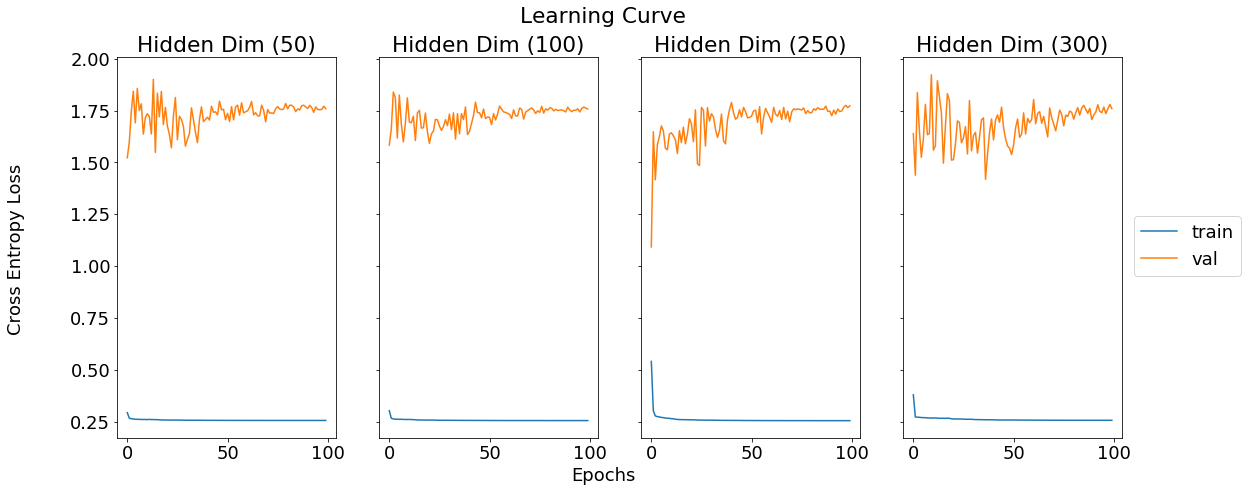

In [45]:
model_results = [
    lstm_results["LSTM Network 1"][0], lstm_results["LSTM Network 2"][0], 
    lstm_results["LSTM Network 3"][0], lstm_results["LSTM Network 4"][0]
]
labels = [
    "Hidden Dim (50)", "Hidden Dim (100)", 
    "Hidden Dim (250)", "Hidden Dim (300)"
]

plt.rcParams.update({'font.size':18})

fig, axn = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches((18,7))
fig.suptitle("Learning Curve")
for i, (ax, data, plot_title) in enumerate(zip(axn, model_results, labels)):
    l1, l2 = ax.plot(data['epoch'], data["train_loss"], data['epoch'], data["val_loss"])
    ax.set_title(plot_title)
    if i == 0:
        fig.legend((l1, l2), ("train", "val"), 'center right')
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.04, 0.5, 'Cross Entropy Loss', va='center', rotation='vertical')

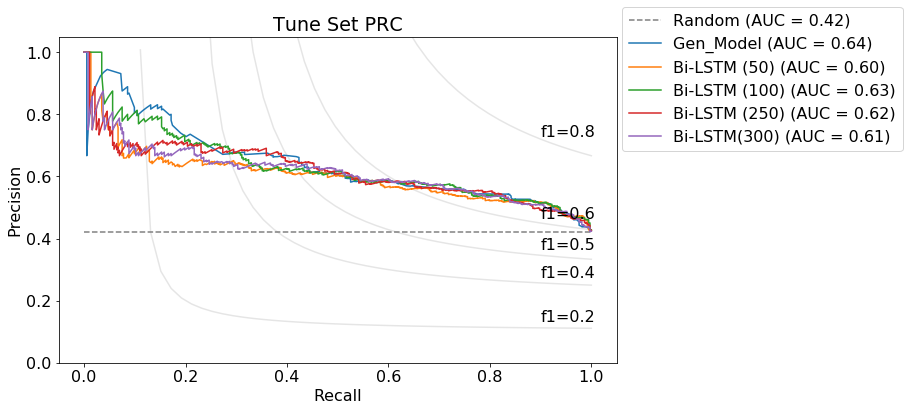

In [47]:
lstm_dev_df = pd.DataFrame(
        pd.np.stack([
            gen_model_dev_df["gen_model"].values,
            lstm_results["LSTM Network 1"][1][ lstm_results["LSTM Network 1"][3]].values,
            lstm_results["LSTM Network 2"][1][ lstm_results["LSTM Network 2"][3]].values,
            lstm_results["LSTM Network 3"][1][ lstm_results["LSTM Network 3"][3]].values,
            lstm_results["LSTM Network 4"][1][ lstm_results["LSTM Network 4"][3]].values
        ],
            axis=1), 
        columns=["Gen_Model", "Bi-LSTM (50)", "Bi-LSTM (100)","Bi-LSTM (250)", "Bi-LSTM(300)"]
    )
aucs=plot_curve(
    lstm_dev_df,
    dev_Y.numpy(), 
    plot_title="Tune Set PRC", 
    metric="PR", 
    model_type="curve"
)

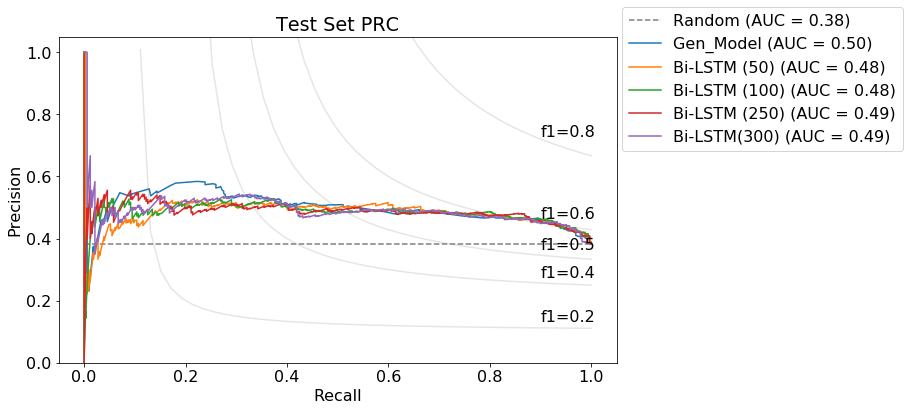

In [49]:
lstm_test_df = pd.DataFrame(
        pd.np.stack([
            gen_model_test_df["gen_model"].values,
            lstm_results["LSTM Network 1"][2][lstm_results["LSTM Network 1"][3]].values,
            lstm_results["LSTM Network 2"][2][lstm_results["LSTM Network 2"][3]].values,
            lstm_results["LSTM Network 3"][2][lstm_results["LSTM Network 3"][3]].values,
            lstm_results["LSTM Network 4"][2][lstm_results["LSTM Network 4"][3]].values
        ],
            axis=1), 
        columns=["Gen_Model", "Bi-LSTM (50)","Bi-LSTM (100)", "Bi-LSTM (250)", "Bi-LSTM(300)"]
    )
aucs=plot_curve(
    lstm_test_df,
    test_Y.numpy(), 
    plot_title="Test Set PRC", 
    metric="PR", 
    model_type="curve"
)

# Visualize LSTM Attention Layer

In [50]:
word_dict_df = pd.read_table("single_task_data/word_dictionary.tsv.xz")
reverse_dict = {index:word for word, index in word_dict_df[["word", "index"]].values}
word_dict_df.head(2)

,word,index
0,of,2
1,~~[[2,3


In [174]:
index = 234
words = [reverse_dict[col.item()] for col in dev_X[index] if col > 0]
attn_df_dict = get_attn_scores(lstm_model_paths, lstm_end_models, dev_X[index:index+1], words)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [175]:
print(" ".join(words))
print()
print("P(Y|X) = {:.2f}".format(lstm_results["LSTM Network 3"][1][lstm_results["LSTM Network 3"][3]].iloc[index]))
print("True Y = {}".format(dev_Y[index]))

~~[[2 stat3 2]]~~ , a downstream signal transducer , was essential for ~~[[1 lif 1]]~~ activity as infection with adenoviruses expressing a *unknown* stat3 mutant rendered endothelial cells insensitive to the antiproliferative action of lif .

P(Y|X) = 1.00
True Y = 2


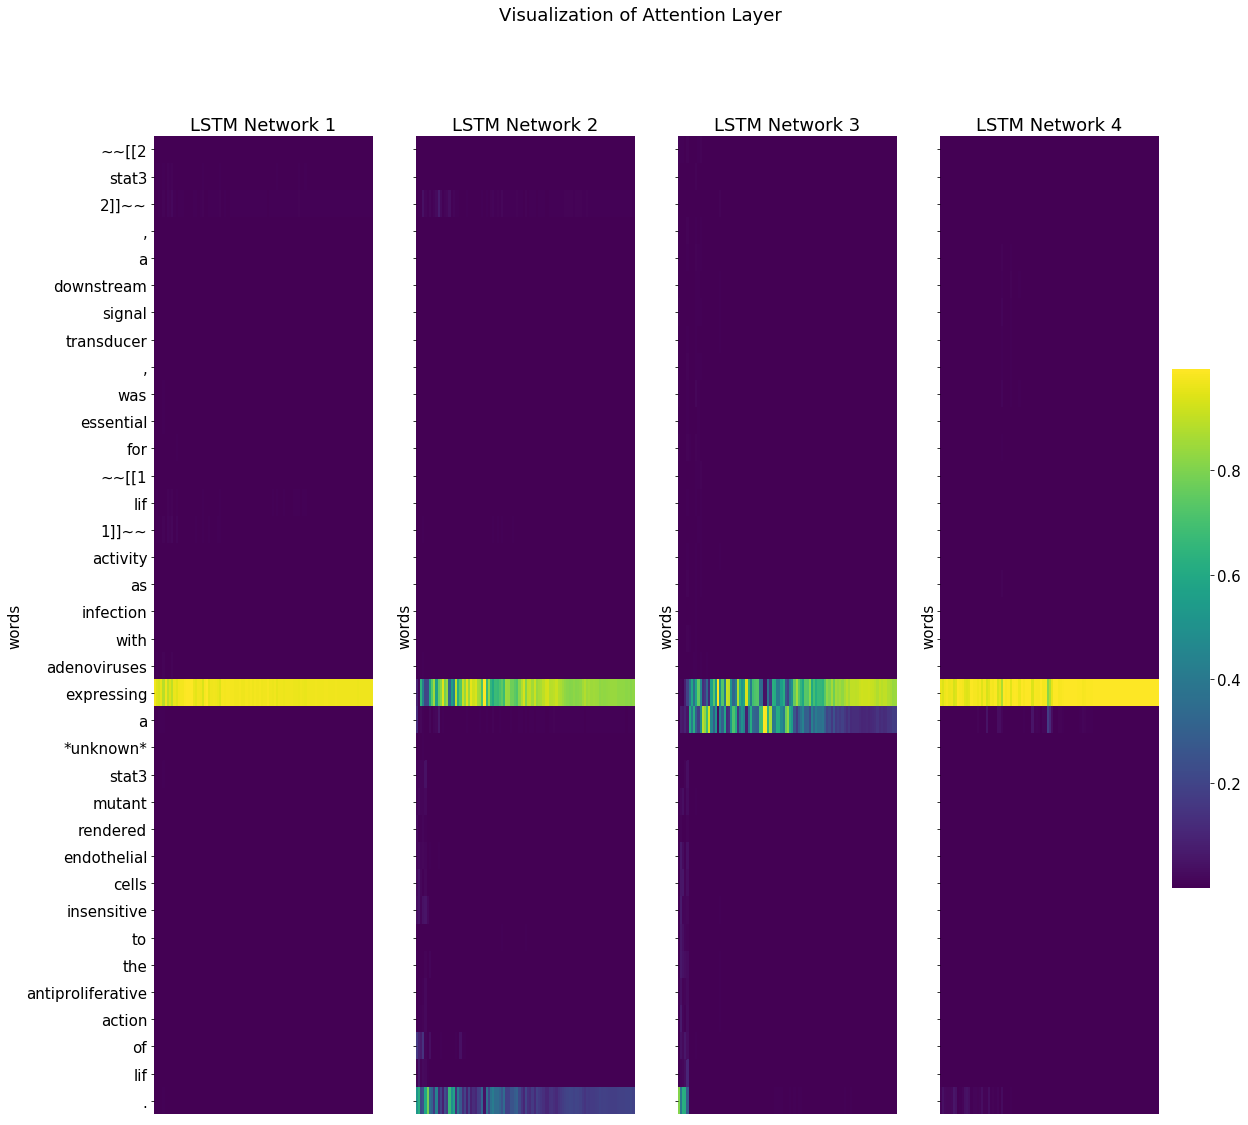

In [176]:
plt.rcParams.update({'font.size':15})
fig, axn = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches((18,18))
fig.suptitle("Visualization of Attention Layer")
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, (ax, key) in enumerate(zip(axn.flat, attn_df_dict.keys())):
    sns.heatmap(
        attn_df_dict[key].set_index("words"),
        annot=False,
        cmap='viridis',
        xticklabels=False,
        ax=ax,
        cbar_ax = None if i else cbar_ax,
        cbar = (i==0)
    )
    ax.set_title(key)

In [178]:
index = 365
words = [reverse_dict[col.item()] for col in dev_X[index] if col > 0]
attn_df_dict = get_attn_scores(lstm_model_paths, lstm_end_models, dev_X[index:index+1], words)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [179]:
print(" ".join(words))
print()
print("P(Y|X) = {:.2f}".format(lstm_results["LSTM Network 3"][1][lstm_results["LSTM Network 3"][3]].iloc[index]))
print("True Y = {}".format(dev_Y[index]))

our findings do not support the hypothesis that ~~[[2 adh1c 2]]~~ variants are associated with ~~[[1 chd 1]]~~ risk in people who drink moderately .

P(Y|X) = 1.00
True Y = 2


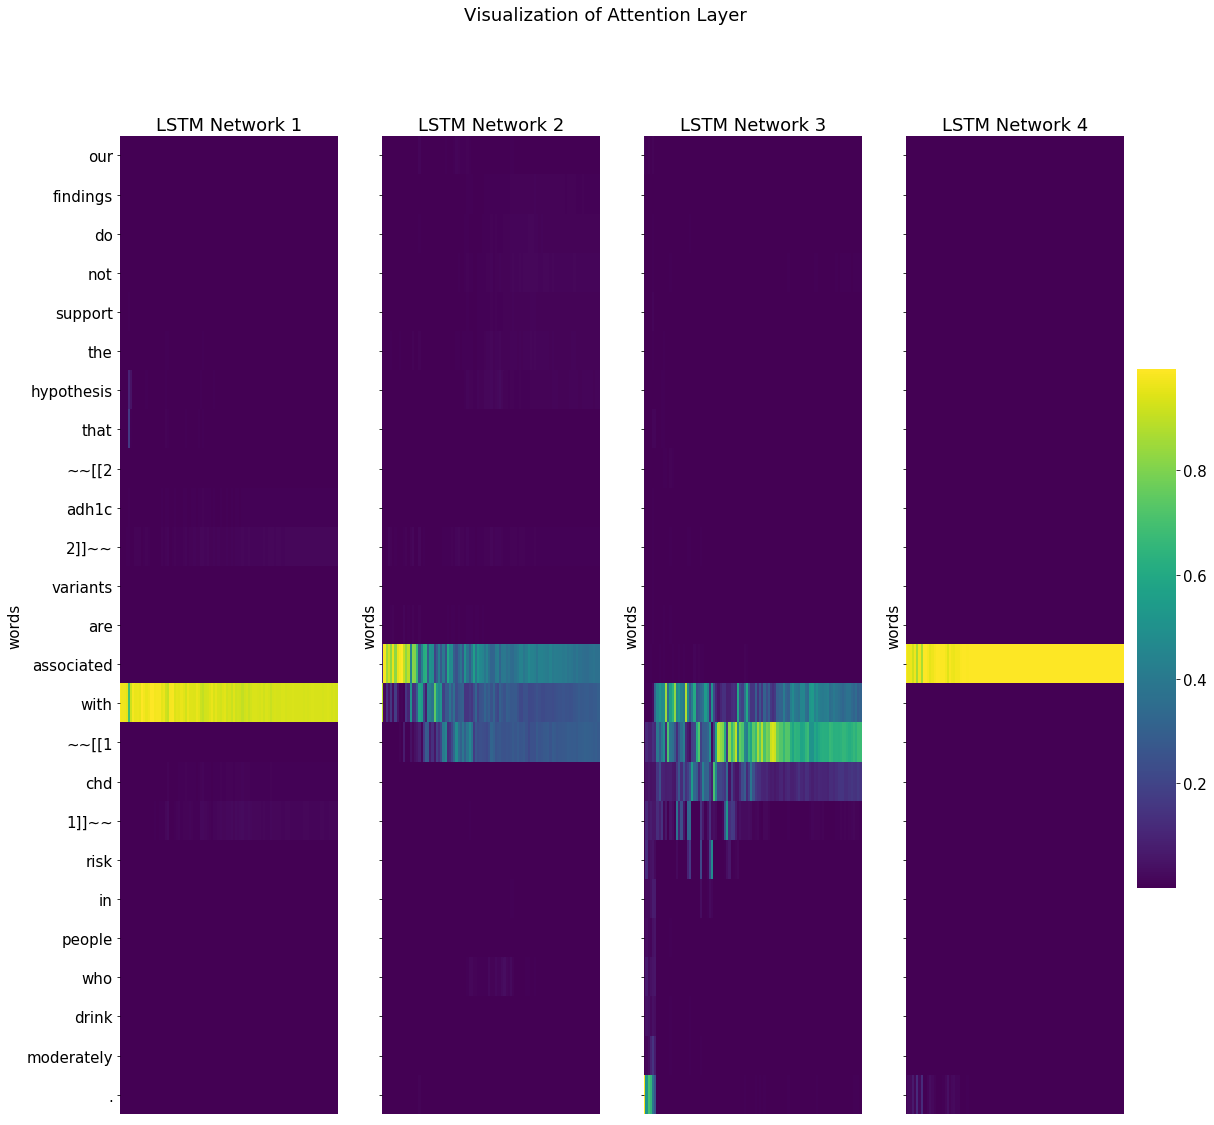

In [180]:
plt.rcParams.update({'font.size':15})
fig, axn = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches((18,18))
fig.suptitle("Visualization of Attention Layer")
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, (ax, key) in enumerate(zip(axn.flat, attn_df_dict.keys())):
    sns.heatmap(
        attn_df_dict[key].set_index("words"),
        annot=False,
        cmap='viridis',
        xticklabels=False,
        ax=ax,
        cbar_ax = None if i else cbar_ax,
        cbar = (i==0)
    )
    ax.set_title(key)

# CNN Network Evaluation

Used a LSTM network with an attention layer at the end. The following parameters for the network is produced below in the table:

| Parameter | Network 1 | Network 2 | Network 3 | Network 4
|-------|-------|-------|-------|-------|
| Word Embeddings | 300 dim (fixed) | 300 dim (fixed) | 300 dim (fixed) | 300 dim (fixed) |
| kernel Sizes | 7,7,7,7 | 7,7,7,7 | 3,4,5,6 | 10,10,10,10 |
| Batch Norm | Yes | No | Yes | Yes |
| Dropout | 0.5 (outside) | 0.25 (outside) | 0.25 (outside) | 0.25 (outside) | 
| Layers | 2 | 2 | 2 | 2 |
| learning rate | 0.0035 |  0.0035 |  0.0001 |  0.0001 | 
| optimizer | adam with betas(0.9, 0.99)| adam with betas(0.9, 0.99)| adam with betas(0.9, 0.99)| adam with betas(0.9, 0.99)|
| Batch Size | 256 | 256 | 256 | 256 | 
    

In [188]:
cnn_params = {
    "CNN Network 1":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[7,7,7,7],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":True
    },
    "CNN Network 2":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[7,7,7,7],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":False
    },
    "CNN Network 3":{
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[3,4,5,6],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":True
    },
    "CNN Network 4":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[10,10,10,10],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":True
    }
}

In [189]:
cnn_model_paths = {
    "CNN Network 1":sorted(
        glob.glob("single_task_data/final_models/cnn/100_4_7777_frozen_0.0035_batch_norm/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "CNN Network 2":sorted(
        glob.glob("single_task_data/final_models/cnn/100_4_7777_frozen_0.0035_no_batch/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "CNN Network 3":sorted(
        glob.glob("single_task_data/final_models/cnn/100_4_3456_frozen_0.0001_batch_norm/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "CNN Network 4":sorted(
        glob.glob("single_task_data/final_models/cnn/100_4_10101010_frozen_0.0001_batch_norm/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    )
}

In [183]:
cnn_end_models= {}

In [190]:
for network in cnn_params:
    cnn_end_models[network] = EndModel(
    [cutoff-1, 100*len(cnn_params[network]["kernel_sizes"]), 2], 
    input_module=PaddedEmbeddings(
        cnn_params[network]["vocab_size"], cnn_params[network]["hidden_size"], freeze=True
        ),
    middle_modules=[CNN(100, cnn_params[network]["kernel_sizes"], 59, 300)],
    seed=cnn_params[network]["seed"], 
    use_cuda=False,
    middle_layer_config = {
    'middle_relu':False,
    'middle_dropout': 0.25,
    'middle_batchnorm':cnn_params[network]["batchnorm"],
    },
    input_layer_config = {
        'input_relu':False,
        'input_batchnorm':False,
        'input_dropout': 0,
    }
)


Network architecture:
Sequential(
  (0): PaddedEmbeddings(
    (embed): Embedding(54074, 300, padding_idx=0)
  )
  (1): Sequential(
    (0): CNN(
      (conv1): Conv2d(1, 100, kernel_size=(7, 300), stride=(1, 1))
      (pool1): MaxPool2d(kernel_size=(53, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(1, 100, kernel_size=(7, 300), stride=(1, 1))
      (pool2): MaxPool2d(kernel_size=(53, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
      (conv3): Conv2d(1, 100, kernel_size=(7, 300), stride=(1, 1))
      (pool3): MaxPool2d(kernel_size=(53, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
      (conv4): Conv2d(1, 100, kernel_size=(7, 300), stride=(1, 1))
      (pool4): MaxPool2d(kernel_size=(53, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
    )
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25)
  )
  (2): Linear(in_features=400, out_features=2, bias=True)
)


Network archit

In [191]:
cnn_results = {}
for network in cnn_model_paths:
    cnn_results[network] = get_network_results(
        cnn_model_paths[network], cnn_end_models[network], 
        dev_X, test_X
    )

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

In [192]:
cnn_results[network][0].head(2)

,epoch,train_loss,val_loss,lr,f1
0,0.0,0.641946,0.663811,0.0001,0.497222
1,1.0,0.619948,0.668426,0.0001,0.519231


In [193]:
cnn_results[network][1].head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.609477,0.514759,0.491082,0.560320,0.571775,0.568327,0.522181,0.558186,0.649170,0.599549,...,0.541443,0.363250,0.438756,0.423445,0.479850,0.425116,0.374063,0.386603,0.505761,0.395510
1,0.275351,0.275100,0.206265,0.235355,0.286438,0.284147,0.242494,0.222498,0.336441,0.301960,...,0.133375,0.235744,0.184892,0.180740,0.191061,0.255359,0.242927,0.226020,0.291711,0.228851


In [194]:
cnn_results[network][2].head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.646529,0.682016,0.720993,0.734580,0.701750,0.694746,0.703626,0.711731,0.687986,0.745715,...,0.749362,0.692360,0.647143,0.784683,0.702037,0.688446,0.528384,0.736312,0.728303,0.616487
1,0.436640,0.434970,0.422439,0.444711,0.412813,0.448108,0.333941,0.430513,0.419050,0.349740,...,0.213004,0.286416,0.235377,0.253427,0.303548,0.344176,0.208484,0.318041,0.320824,0.241066


In [195]:
cnn_results[network][3]

22

Text(0.04,0.5,'Cross Entropy Loss')

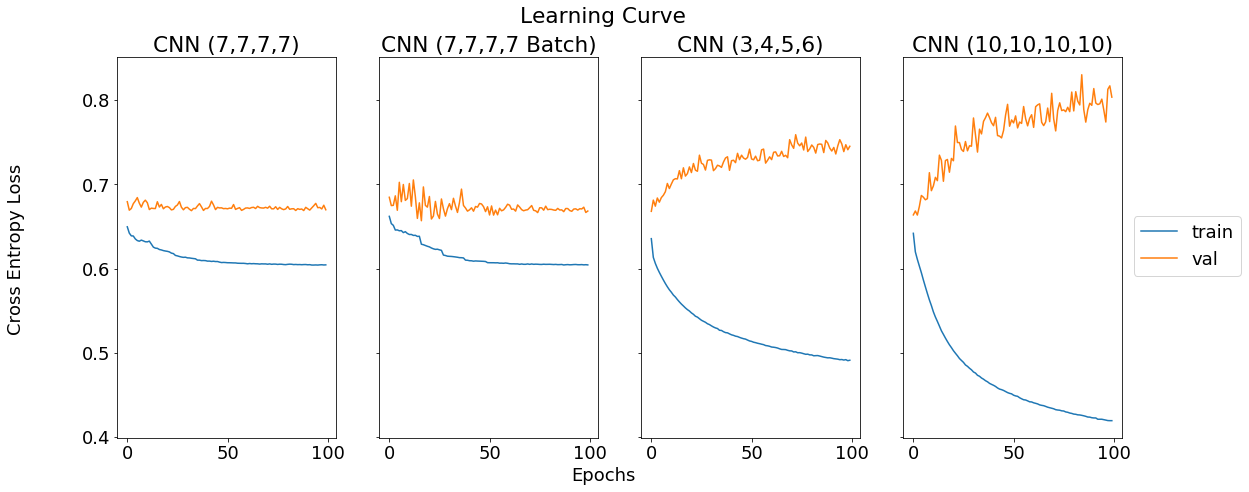

In [196]:
cnn_model_results = [
    cnn_results["CNN Network 1"][0],cnn_results["CNN Network 2"][0],
    cnn_results["CNN Network 3"][0], cnn_results["CNN Network 4"][0]
]
cnn_labels = [
    "CNN (7,7,7,7)", "CNN (7,7,7,7 Batch)", 
    "CNN (3,4,5,6)", "CNN (10,10,10,10)"
]

plt.rcParams.update({'font.size':18})

fig, axn = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches((18,7))
fig.suptitle("Learning Curve")
for i, (ax, data, plot_title) in enumerate(zip(axn.flat, cnn_model_results, cnn_labels)):
    l1, l2 = ax.plot(data['epoch'], data["train_loss"], data['epoch'], data["val_loss"])
    ax.set_title(plot_title)
    if i == 0:
        fig.legend((l1, l2), ("train", "val"), 'center right')
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.04, 0.5, 'Cross Entropy Loss', va='center', rotation='vertical')

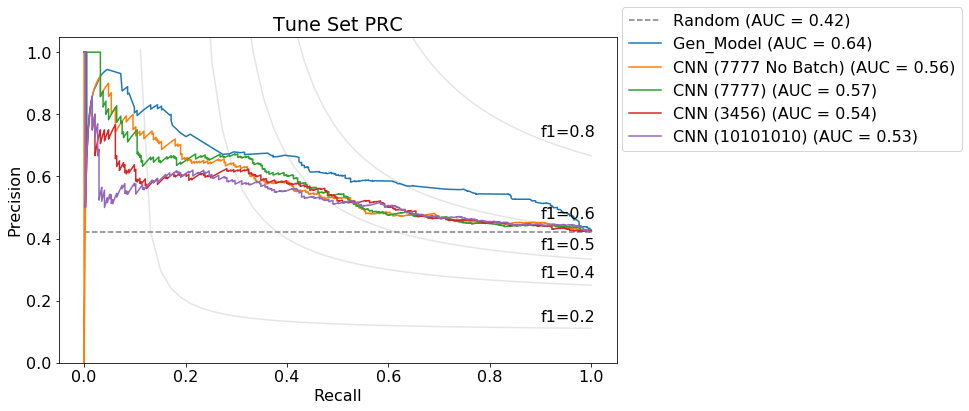

In [198]:
cnn_dev_df = pd.DataFrame(
        pd.np.stack([
            gen_model_dev_df["gen_model"].values,
            cnn_results["CNN Network 1"][1][cnn_results["CNN Network 1"][3]].values,
            cnn_results["CNN Network 2"][1][cnn_results["CNN Network 2"][3]].values,
            cnn_results["CNN Network 3"][1][cnn_results["CNN Network 3"][3]].values,
            cnn_results["CNN Network 4"][1][cnn_results["CNN Network 4"][3]].values,
        ],
            axis=1), 
        columns=["Gen_Model", "CNN (7777 No Batch)", "CNN (7777)", "CNN (3456)", "CNN (10101010)"]
    )
aucs=plot_curve(
    cnn_dev_df,
    dev_Y.numpy(), 
    plot_title="Tune Set PRC", 
    metric="PR", 
    model_type="curve"
)

In [199]:
best_cnn_dev = cnn_results["CNN Network 2"][1][cnn_results["CNN Network 2"][3]].values 
best_lstm_dev = lstm_results["LSTM Network 3"][1][lstm_results["LSTM Network 3"][3]].values 
best_cnn_test = cnn_results["CNN Network 2"][2][cnn_results["CNN Network 2"][3]].values 
best_lstm_test = lstm_results["LSTM Network 3"][2][lstm_results["LSTM Network 3"][3]].values 

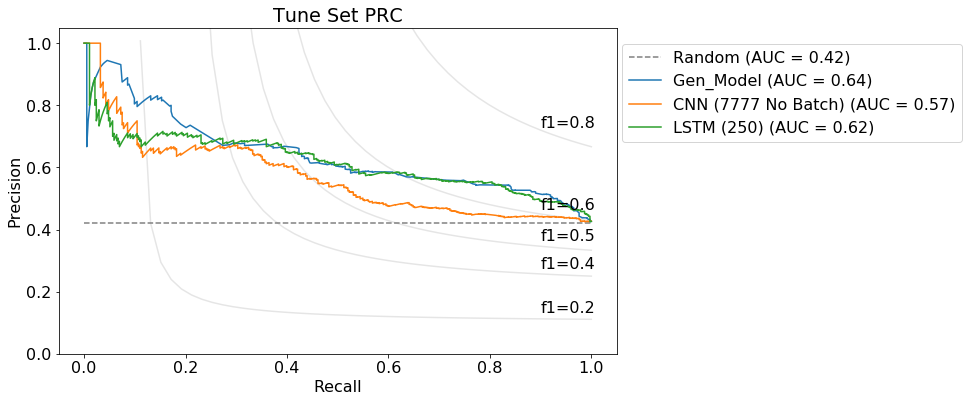

In [200]:
final_dev_df = pd.DataFrame(
        pd.np.stack([
            gen_model_dev_df["gen_model"].values,
            best_cnn_dev,
            best_lstm_dev
        ],
            axis=1), 
        columns=["Gen_Model", "CNN (7777 No Batch)", "LSTM (250)"]
    )
aucs=plot_curve(
    final_dev_df,
    dev_Y.numpy(), 
    plot_title="Tune Set PRC", 
    metric="PR", 
    model_type="curve"
)

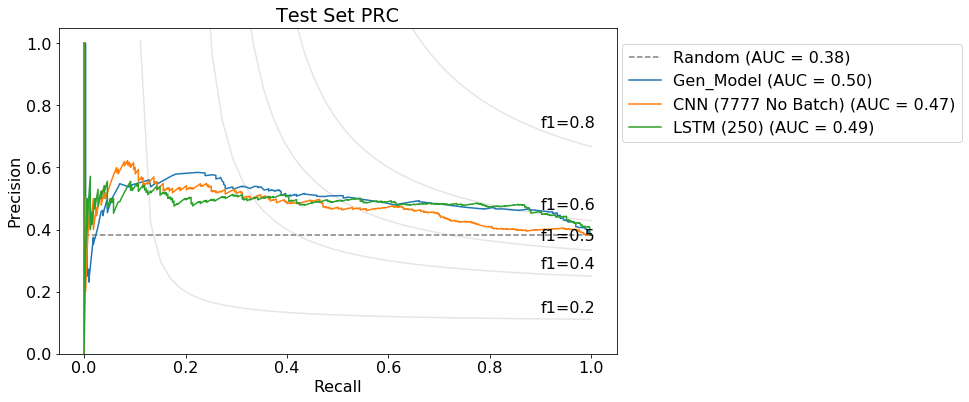

In [202]:
final_test_df = pd.DataFrame(
        pd.np.stack([
            gen_model_test_df["gen_model"].values,
            best_cnn_test,
            best_lstm_test
        ],
            axis=1), 
        columns=["Gen_Model", "CNN (7777 No Batch)", "LSTM (250)"]
    )
aucs=plot_curve(
    final_test_df,
    test_Y.numpy(), 
    plot_title="Test Set PRC", 
    metric="PR", 
    model_type="curve"
)

In [ ]:
error_output_df = (
    candidate_dfs['dev'][[
    'candidate_id', 'disease', 
    'gene', 'doid_id', 
    'entrez_gene_id', 'sentence_id', 
    'sentence', 'curated_dsh'
    ]]
    .merge(gen_model_dev_df[['gen_model', 'candidate_id']], on="candidate_id")
    .sort_values("candidate_id")
)

error_output_df['lstm'] = best_lstm_dev
error_output_df['cnn'] = best_cnn_dev
error_output_df.head(2)

In [ ]:
spreadsheet_name = "single_task_data/sentence_dev_error_analysis.xlsx"
writer = pd.ExcelWriter(spreadsheet_name)

(
    error_output_df
    .to_excel(writer, sheet_name='sentences', index=False)
)

if writer.engine == 'xlsxwriter':
    for sheet in writer.sheets.values():
        sheet.freeze_panes(1, 0)

writer.close()